In [1]:
! pip install transformers
! pip install torch
! pip install pandas


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
   

""" Module for loading dataset """
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    f1_score,
    precision_recall_fscore_support,
)
import matplotlib.pyplot as plt
import seaborn as sns
    
import torch
import importlib
import random
import re  
import os
from transformers import logging

logging.set_verbosity(40)
os.environ["TOKENIZERS_PARALLELISM"] = "false"
random.seed(42)


In [11]:
config={"classes":{"Data":0,"Documentation":1,"Mission and Instruments":2,"image":3,"Software and tools":4,"Training and Education":5},
"preprocess":
                {"processed_data":"final_data.csv",
                "train_size":0.7,
                "valid_size":0.1},
"encoder":  {
    "image_keyword":["image","images","photojournal","view","Images","Related"],
    "software_keyword":["software","tools","SDK","API","toolkit","library","application","code",
    "class","package","interface","annotation","index","tree",
    "constructor","method","version","model","attributes","methods","seed",
    "version","command","log","undo","fit","method","disk","settings","save","programming","object","code","script","language",
    "scripting","embedding","function","C++","Fortran","bug","installation",
    "syntax","interface","architecture","prompt","parameter",
    "graphics","comment","wrapper","terminal","plot","show"
    ,"save","clear","default","input","output","query","component","add","remove","framework","instruction",
    "pan","view","browse","button","coordinates","position","zoom","dropdown","search","git","github"],
    "mission_keyword":["mission","instruments","trajectory","meter","spacecraft","project","objectives","measurement","aircraft","camera",
    "campaign","flight","radar","test","mobility","curiosity","suspension","investigate"],
    "training_keyword":["training","education"]
},
"dataload":{
    "batch_size":8},
"model_parameters":{
    "model":"AutoModelForSequenceClassification",
    "tokenizer":"AutoTokenizer",
    "model_type":"xlnet-base-cased",
    "module_name":"transformers",
    "learning_rate":0.00001,
    "epochs":2,
    "batch_size":8,
    "saved_model_name":"model.pt",
    "num_labels":6,
    "device":"cpu",
    "optimizer":"AdamW",
    "scheduler":"get_linear_schedule_with_warmup"
}
}


class Encoder:
    def __init__(self, config, data):
        """
        Initializes an Encoder object.

        Args:
            data: The data to be encoded.
            config (dict): A dictionary containing configuration parameters for the encoder.

        """
        self.image_keyword = config["encoder"]["image_keyword"]
        self.software_keyword = config["encoder"]["software_keyword"]
        self.mission_keyword = config["encoder"]["mission_keyword"]
        self.training_keyword=config["encoder"]["training_keyword"]
        self.data = data
        self.encoded_data = pd.DataFrame()


    @classmethod
    def from_dict(cls, cfg: dict, data):
        """
        Creates an Encoder object from a dictionary and data.

        Args:
            cfg (dict): A dictionary containing configuration parameters for the encoder.
            data: The data to be encoded.

        Returns:
            Encoder: An instance of the Encoder class.

        """
        return cls(cfg, data)


    def generate_text_slice(self, word_positions, text_whole):
        """
        Generates a text slice based on the positions of specific words in the given text.

        Args:
            word_positions (dict): A dictionary containing the positions of 
            specific words in the text.
            text_whole (str): The text which needs to be sliced
        Returns:
            str: The extracted text slice based on the positions of the words.

        """
        # Find the minimum position of the words
        min_position = min(min(positions) for positions in word_positions.values())
        # Calculate the start and end indices for the text slice
        start_index = max(min_position[0] - 50, 0)
        end_index = min(start_index + 1000, len(text_whole) - 1)
        # Extract the text slice based on the start and end indices
        text_slice = text_whole[start_index:end_index]
        return text_slice


    def extract_text(self, text):
        """
        Extracts a text slice based on the occurrence and positions of specific keywords.

        Args:
            text (str): The input text to extract the slice from.

        Returns:
            str: The extracted text slice based on the positions of the keywords.

        """

        keywords = self.image_keyword + self.software_keyword + self.mission_keyword+self.training_keyword
        software_count, mission_count, image_count,training_count = 0, 0, 0,0
        word_positions = {}
        start = -1
        for word in text.split():
            start = text.find(word, start + 1)
            end = start + len(word)
            if word in keywords and word not in word_positions:
                word_positions[word] = []

            if word in self.image_keyword:
                image_count = image_count + 1
                word_positions[word].append((start, end))

            if word in self.software_keyword:
                software_count = software_count + 1
                word_positions[word].append((start, end))

            if word in self.mission_keyword:
                mission_count = mission_count + 1
                word_positions[word].append((start, end))

            if word in self.training_keyword:
                training_count = training_count + 1
                word_positions[word].append((start, end))

        if software_count == 0 and mission_count == 0 and image_count == 0 and training_count==0:
            mid = int(len(text) / 2)
            start_pos = mid - 512
            end_pos = mid + 512  # in terms of characters
            text_slice = text[start_pos:end_pos]
        else:
            text_slice = self.generate_text_slice(word_positions, text)
        return text_slice

    def encoder(self):
        """
        Encodes the data by processing the text and classes.

        Returns:
            pandas.DataFrame: The encoded data with processed text and classes.

        """
        text_list, class_list = [], []
        for _, row in self.data.iterrows():
            text = row["text"]
            classes = row["class"]
            counter = text.split()
            if len(counter) <= 400:
                text_list.append(text)
                class_list.append(classes)
            elif len(counter) > 400:
                text = self.extract_text(text)
                text_list.append(text)
                class_list.append(classes)
        self.encoded_data["text"] = text_list
        self.encoded_data["class"] = class_list
        return self.encoded_data

class DataLoad:
    def __init__(self, batch_size=8):
        """
        Initializes a new instance of the class.

        Args:
            config (dict): Configuration parameters for the class.
            batch_size (int): The batch size for data loading. Default is 8.

        Attributes:
            train_dataset: The training dataset.
            val_dataset: The validation dataset.
            test_dataset: The test dataset.
            batch_size (int): The batch size for data loading.
            self.train_dataset=None
            self.val_dataset=None
            self.test_dataset=None
            self.batch_size=batch_size
        """

        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.batch_size = batch_size

    @classmethod
    def from_dict(cls, cfg: dict):
        """
        Creates an DataLoad object from a dictionary

        Args:
            cfg (dict): A dictionary containing configuration parameters for the loader

        Returns:
            DataLoad: An instance of the DataLoad class.

        """
        return cls(batch_size=cfg.get("dataload", {}).get("batch_size"))


    def dataset(self, token_results):
        """
        Split the samples into training, validation, and test datasets, and create
        TensorDatasets for each split.

        Args:
            token_results (dictionary): a dictonary containing information about input_ids, attention_masks,
            labels, and indices for training set, test set and validation set.
        Returns:
            None
        """
        input_ids, attention_masks = (
            token_results["input_ids"],
            token_results["attention_masks"],
        )
        labels = token_results["labels"]
        train_idx = token_results["train_idx"]
        val_idx, test_idx = token_results["val_idx"], token_results["test_idx"]
        # Split the samples, and create TensorDatasets for each split.
        self.train_dataset = TensorDataset(
            input_ids[train_idx],
            attention_masks[train_idx],
            labels[train_idx],
        )
        self.val_dataset = TensorDataset(
            input_ids[val_idx],
            attention_masks[val_idx],
            labels[val_idx],
        )
        self.test_dataset = TensorDataset(
            input_ids[test_idx],
            attention_masks[test_idx],
            labels[test_idx],
        )

    def dataloader(self):
        """
        Create data loaders for training, validation, and prediction.

        Returns:
            train_dataloader (DataLoader): Data loader for the training samples.
            validation_dataloader (DataLoader): Data loader for the validation samples.
            prediction_dataloader (DataLoader): Data loader for the prediction samples.
        """
        train_dataloader = DataLoader(
            self.train_dataset,  # The training samples.
            sampler=RandomSampler(self.train_dataset),  # Select batches randomly
            # shuffle=True,
            batch_size=self.batch_size,  # Trains with this batch size.
        )

        # For validation the order doesn't matter, so we'll just read them sequentially.
        validation_dataloader = DataLoader(
            self.val_dataset,  # The validation samples.
            sampler=SequentialSampler(
                self.val_dataset
            ),  # Pull out batches sequentially.
            batch_size=self.batch_size,  # Evaluate with this batch size.
        )

        prediction_sampler = SequentialSampler(self.test_dataset)
        prediction_dataloader = DataLoader(
            self.test_dataset, sampler=prediction_sampler, batch_size=self.batch_size
        )
        return (
            train_dataloader,
            validation_dataloader,
            prediction_dataloader,
        )
    
    


def flat_accuracy(preds, labels):
    """
    Calculates the accuracy of the predictions by comparing them with the ground truth labels.
    Args:
        preds (numpy.ndarray): Array containing model predictions.
        labels (numpy.ndarray): Array containing ground truth labels.
    Returns:
        The accuracy of the predictions as a float.
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


def classwise_accuracy(preds, labels, classes):
    """
    This function calculates class-wise accuracy and generates a confusion matrix,
    classification report
    Parameters:
    - preds: Predicted labels.
    - labels: True labels.
    - classes: Dictionary containing class labels as keys and corresponding class names as values.
    """
    confusion__matrix = confusion_matrix(labels, preds)
    # Plot confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        confusion__matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=list(classes.keys()),
        yticklabels=list(classes.keys()),
    )
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")

    # Calculate class-wise accuracy
    class_accuracies = {}
    for i in range(confusion__matrix.shape[0]):
        class_label = list(classes.keys())[i]
        class_total = confusion__matrix[i].sum()
        class_correct = confusion__matrix[i, i]
        accuracy = class_correct / class_total
        class_accuracies[class_label] = accuracy
    print("class-accuracies", class_accuracies)
    accuracies = pd.DataFrame(
        list(class_accuracies.items()), columns=["Class", "Accuracy"]
    )
    report = classification_report(
        labels, preds, target_names=list(classes.keys()), output_dict=True
    )
    print("The classification report is",report)

def metrics(preds, labels, classes):
    """
    This function calculates performance metrics for a multi-class classification task.
    Parameters:
    - preds: Predicted labels or probabilities from the model. It should be a list
    of arrays or lists.
    - labels: True labels for the corresponding predictions. It should be a list of arrays or lists.
    - classes: List of class labels.
    Returns:
    A dictionary containing the calculated performance metrics.
    """
    performance_metrics = {}
    pred_flat = [np.argmax(arr, axis=1).tolist() for arr in preds]
    pred_flat = [i for lis in pred_flat for i in lis]
    labels_flat = [i.tolist() for i in labels]
    labels_flat = [i for lis in labels_flat for i in lis]
    classwise_accuracy(pred_flat, labels_flat, classes)

    performance_metrics["accuracy"] = np.sum(
        np.array(pred_flat) == np.array(labels_flat)
    ) / len(labels_flat)
    performance_metrics["f1score"] = f1_score(labels_flat, pred_flat, average="micro")
    precision, recall, _, _ = precision_recall_fscore_support(
        labels_flat, pred_flat, average="micro"
    )
    performance_metrics["precision"] = precision
    performance_metrics["recall"] = recall
    return performance_metrics


def print_metrics(result, mode):
    """
    Prints metrics evaluated
    Args: Dictionary
    """
    recall = result["recall"]
    precision = result["precision"]
    f1score = result["f1score"]
    accuracy = result["accuracy"]
    print(f"{mode} Precision: {precision}")
    print(f"{mode} recall: {recall}")
    print(f"{mode} f1_score: {f1score}")
    print(f"{mode} accuracy: {accuracy}")
    


class ModelBert:
    """
    A class for predicting the correct long form for a given acronym
    in a context paragraph using a pre-trained BERT model and tokenizer.

    """

    def __init__(self, config, num_labels=5, device="cpu"):
        self.config = config["model_parameters"]
        self.num_labels = num_labels
        self.device = torch.device(device)
        self.model = None
        self.tokenizer = None
        self.state_dict = None

    @classmethod
    def from_dict(cls, cfg: dict):
        """
        Creates an ModelBert object from a dictionary.

        Args:
            cfg (dict): A dictionary containing configuration parameters for the encoder.
            data: The data to be encoded.

        Returns:
            ModelBert: An instance of the ModelBert class.

        """
        model_parameters = cfg.get("model_parameters")
        return cls(
            cfg,
            num_labels=model_parameters.get("num_labels"),
            device=model_parameters.get("device"),
        )

    def make_model(self):
        """
        Instantiates a pre-trained BERT model and tokenizer.
        Returns:
            A tuple containing the model and the tokenizer.
        """
        # Dynamicall import the transformers module
        module_name = self.config["module_name"]
        transformers = importlib.import_module(module_name)
        # Dynamically get the model class from transformers module
        model_class = getattr(transformers, self.config["model"])
        tokenizer_class = getattr(transformers, self.config["model"])
        # Load the tokenizer and model
        self.tokenizer = tokenizer_class.from_pretrained(self.config["model_type"])
        self.model = model_class.from_pretrained(
            self.config["model_type"], num_labels=self.config["num_labels"]
        ).to(self.device)
        return self.model, self.tokenizer

    def load_model(self):
        """This function loads the models and processes the data for evaluation"""
        self.state_dict = torch.load(
            self.config["saved_model_name"], map_location=self.device
        )
        model1, _ = self.make_model()
        model1.load_state_dict(self.state_dict)
        return model1


class Predictor:
    def __init__(self, config):
        """
        Initializes an instance of the class.
        """
        self.config = config
        self.device = config["device"]

    @classmethod
    def from_dict(cls, cfg: dict):
        """
        Creates an Predictor object from a dictionary and data.

        Args:
            cfg (dict): A dictionary containing configuration parameters for the encoder.
            data: The data to be encoded.

        Returns:
            Predictor: An instance of the Predictor class.

        """
        config = cfg.get("model_parameters")
        return cls(config)

    def convert_labels_to_class(self, true_labels, pred_labels):
        """
        Converts the numeric class labels to their corresponding class names.

        Args:
            true_labels (list): List of true class labels.
            pred_labels (list): List of predicted class labels.

        Returns:
            true_labels (list): List of true class names.
            pred_labels (list): List of predicted class names.
        """
        classes = [
            "Data",
            "Documentation",
            "mission_instruments",
            "image",
            "Software_tools",
            "Training and Education"
        ]
        true_labels = [classes[i] for i in true_labels]
        pred_labels = [classes[i] for i in pred_labels]
        return true_labels, pred_labels

    def prediction(self, prediction_dataloader, model):
        """
        Performs predictions on a given dataset using the provided model.

        Args:
            prediction_dataloader (DataLoader): The dataloader for the prediction dataset.
            model: The trained model for making predictions.

        Returns:
            predictions (list): List of predicted probabilities for each class.
            true_labels (list): List of true class labels.
        """
        model.eval()
        # tracking variables
        predictions, true_labels = [], []
        for batch in prediction_dataloader:
            # Add batch to CPU
            batch = tuple(t.to(self.device) for t in batch)

            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch

            # Telling the model not to compute or store gradients, saving memory and
            # speeding up prediction
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                result = model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    return_dict=True,
                )
            logits = result.logits
            logits = torch.sigmoid(logits)
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to("cpu").numpy()
            # Store predictions and true labels
            predictions.append(logits)
            true_labels.append(b_labels)
        pred_flat = [np.argmax(arr, axis=1).tolist() for arr in predictions]
        pred_flat = [i for lis in pred_flat for i in lis]
        labels_flat = [i.tolist() for i in true_labels]
        labels_flat = [i for lis in labels_flat for i in lis]
        labels_flat, pred_flat = self.convert_labels_to_class(labels_flat, pred_flat)
        table = pd.DataFrame(
            {"predictions": pred_flat, "truth": labels_flat}
        )
        table.to_csv("test_data_prediction.csv")
        return predictions, true_labels
    


class Preprocessor:
    def __init__(self, config, data):
        """
        Initializes a Preprocessor object.

        Args:
            data: The data to be processed.

        """
        self.data = data
        self.config = config

    @classmethod
    def from_dict(cls, cfg: dict, data):
        """
        Creates an Encoder object from a dictionary and data.

        Args:
            cfg (dict): A dictionary containing configuration parameters for the encoder.
            data: The data to be encoded.

        Returns:
            Encoder: An instance of the Encoder class.

        """
        return cls(cfg, data)


    def preprocessed_features(self):
        """
        Preprocesses the features of the data by removing header and footer, extracting text
        from HTML content.
        Returns:
            pandas.DataFrame: The preprocessed data with columns text and class.
        """
        self.data["text"] = self.data["text"].apply(
            lambda x: re.sub(r"\W+", " ", x.strip())
        )
        return self.data

    
class Tokenizer:
    '''
    class for tokenizing the input
    '''
    def __init__(self, config):
        """
        Initializes a Tokenizer object.

        Args:
            data: The data to be encoded.
            config (dict): A dictionary containing configuration parameters for the encoder.

        """
        data_path = config["preprocess"]["processed_data"]
        self.data = pd.read_csv(data_path,encoding='latin-1')
        self.config = config
        self.final_data = pd.DataFrame(columns=["text", "class"])
        self.train_idx = []
        self.test_idx = []
        self.val_idx = []

    @classmethod
    def from_dict(cls, cfg: dict):
        """
        Creates an Encoder object from a dictionary and data.

        Args:
            cfg (dict): A dictionary containing configuration parameters for the encoder.
            data: The data to be encoded.

        Returns:
            Encoder: An instance of the Encoder class.

        """
        return cls(cfg)

    def train_test_split(self):
        """
        Performs the train-test split on the data, preprocesses the features,
        encodes the data, and sets the indices for the training, validation, and
        test sets.

        Returns:
            None
        """
        # Randomly shuffle the rows
        self.data = self.data.sample(frac=1, random_state=42)
        # Reset the index of the shuffled DataFrame
        self.data = self.data.reset_index(drop=True)

        processor = Preprocessor.from_dict(self.config, self.data)
        dataframe = processor.preprocessed_features()
        # Specify the columns you want to select
        self.final_data = pd.DataFrame(
            {
                "text": dataframe["text"],
                "class": dataframe["class"],
            }
        )
        encoder = Encoder.from_dict(self.config, self.final_data)
        self.data = encoder.encoder()
        self.data["final_sentence"] = self.data["text"]
        self.data = self.data.drop(columns=["text"])
        # First, calculate the split sizes. 80% training, 10% validation, 10% test.
        train_size = int(self.config["preprocess"]["train_size"] * len(self.data))
        val_size = int(self.config["preprocess"]["valid_size"] * len(self.data))
        # Create a list of indeces for all of the samples in the dataset.
        indeces = np.arange(0, len(self.data))
        # Find indices of instances from class "5"
        # Shuffle the indeces randomly.
        random.shuffle(indeces)
        # Find indices of instances from class "5"
        class_5_indices = [idx for idx in indeces if self.data["class"][idx] == 5]
        # Separate class 5 indices from the rest
        other_indices = [idx for idx in indeces if idx not in class_5_indices]
        # Get a list of indeces for each of the splits.
        # Ensure there's at least one instance of class "5" in each split
        class_5_train_size=int(len(class_5_indices)*self.config["preprocess"]["train_size"])
        class_5_valid_size=int(len(class_5_indices)*self.config["preprocess"]["valid_size"])
        self.train_idx = class_5_indices[:class_5_train_size-1] + other_indices[:train_size - 1]
        self.val_idx = class_5_indices[class_5_train_size-1:class_5_train_size+class_5_valid_size-2] + other_indices[train_size - 1:train_size + val_size - 2]
        self.test_idx = class_5_indices[class_5_train_size+class_5_valid_size-2:] + other_indices[train_size + val_size - 2:]



    def token(self):
        """
        Tokenizes the sentences, encodes them using tokenizer, and prepares the
        input tensors and labels for training.
        Returns:
            input_ids (torch.Tensor): Tensor of input token IDs for each sentence.
            attention_masks (torch.Tensor): Tensor of attention masks for each sentence.
            labels (torch.Tensor): Tensor of labels for each sentence.
            train_idx (ndarray): Indices for the training set.
            val_idx (ndarray): Indices for the validation set.
            test_idx (ndarray): Indices for the test set.
        """
        self.train_test_split()
        sentence, labels, input_ids, attention_masks = [], [], [], []
        for _, row in self.data.iterrows():
            sentence.append(row["final_sentence"])
            labels.append(row["class"])

        module_name = self.config["model_parameters"]["module_name"]
        transformers = importlib.import_module(module_name)
        # Dynamically get the model class from transformers module
        tokenizer_class = getattr(
            transformers, self.config["model_parameters"]["tokenizer"]
        )
        tokenizer = tokenizer_class.from_pretrained(
            self.config["model_parameters"]["model_type"]
        )

        for sent in sentence:
            encoded_dict = tokenizer.encode_plus(
                text=sent,
                add_special_tokens=True,
                truncation=True,
                max_length=500,
                padding="max_length",
                return_attention_mask=True,
                return_tensors="pt",
            )
            input_ids.append(encoded_dict["input_ids"])
            attention_masks.append(encoded_dict["attention_mask"])
        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
        labels = torch.tensor(labels)
        token_results = {
            "input_ids": input_ids,
            "attention_masks": attention_masks,
            "labels": labels,
            "train_idx": self.train_idx,
            "val_idx": self.val_idx,
            "test_idx": self.test_idx,
        }
        return token_results
    
    


class Trainer:
    '''
    class for training the model
    '''
    def __init__(
        self,
        config,
        learning_rate=0.00001,
        epochs=9,
    ):
        """
        Initializes an instance of the class.

        Args:
            config (dict): A dictionary containing the configuration parameters for the model.
            learning_rate (float, optional): The learning rate for the optimizer.
            epochs (int, optional): The number of training epochs.
            batch_size (int, optional): The batch size for training.
            model_path (str, optional): The path to save the trained model.".
        """
        self.config = config
        self.learning_rate = learning_rate
        self.epochs = epochs
        model = ModelBert.from_dict(self.config)
        self.model, _ = model.make_model()
        self.device = torch.device("cpu")
        module_name = self.config["model_parameters"]["module_name"]
        self.transformers = importlib.import_module(module_name)
        optimizer_class = getattr(
            self.transformers, self.config["model_parameters"]["optimizer"]
        )
        self.optimizer = optimizer_class(
            self.model.parameters(), lr=self.learning_rate, eps=1e-8
        )

    @classmethod
    def from_dict(cls, cfg: dict):
        """
        Creates an Trainer object from a dictionary.

        Args:
            cfg (dict): A dictionary containing configuration parametersr.
            data: The data to be encoded.

        Returns:
            Trainer: An instance of the Trainer class.
        """
        model_parameters = cfg.get("model_parameters")

        return cls(
            cfg,
            learning_rate=model_parameters.get("learning_rate"),
            epochs=model_parameters.get("epochs"),
        )

    def train(self, train_dataloader, validation_dataloader):
        """
        Trains the model on the provided training dataset and validates it using
        the validation dataset.

        Args:
            train_dataloader (DataLoader): The dataloader for the training dataset.
            validation_dataloader (DataLoader): The dataloader for the validation dataset.

        Returns:
            pred (list): The predicted values from the validation dataset.
            labels (list): The actual labels from the validation dataset.
        """
        total_steps = len(train_dataloader) * self.epochs
        scheduler_class = getattr(
            self.transformers, self.config["model_parameters"]["scheduler"]
        )
        scheduler = scheduler_class(
            self.optimizer,
            num_warmup_steps=0,  # Default value in run_glue.py
            num_training_steps=total_steps,
        )
        for epoch_i in range(0, self.epochs):
            print(f"======== Epoch {epoch_i + 1} / {self.epochs} ========")

            print("Training...")
            total_train_loss = 0
            self.model.train()
            num_train_steps = 0
            for _, batch in enumerate(train_dataloader):
                self.model.zero_grad()

                result = self.model(
                    batch[0].to(self.device),
                    token_type_ids=None,
                    attention_mask=batch[1].to(self.device),
                    labels=batch[2].to(self.device),
                    return_dict=True,
                )

                loss = result.loss

                total_train_loss += loss.item()
                loss.mean().backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                self.optimizer.step()
                scheduler.step()
                num_train_steps += 1
            # Calculate the average loss over all of the batches.
            train_loss = total_train_loss / num_train_steps
            print("train loss", train_loss)

            validator = Validator(
                self.model,
                validation_dataloader,
                self.config["model_parameters"]["device"],
            )
            pred, labels = validator.validation()
        torch.save(
            self.model.state_dict(), self.config["model_parameters"]["saved_model_name"]
        )
        return pred, labels


class Validator:
    """
    class for validation dataset
    """

    def __init__(self, model, validation_dataloader, device):
        self.model = model
        self.validation_dataloader = validation_dataloader
        self.device = torch.device(device)

    @classmethod
    def from_dict(cls, cfg, model, validation_dataloader):
        """
        Creates an Validator object from a dictionary.

        Args:
            cfg (dict): A dictionary containing configuration parametersr.
            model: the trained loader
            validation_dataloader: dataloader of validation dataset

        Returns:
            Validator:  An instance of validator class
        """
        model_parameters = cfg.get("model_parameters")
        return cls(model, validation_dataloader, device=model_parameters.get("device"))

    def validation(self):
        """
        Performs validation on the model using the validation dataset.

        Returns:
            tuple: A tuple containing the predicted logits and true labels of the
            validation dataset.

        """
        self.model.eval()
        total_eval_accuracy, total_eval_loss, nb_eval_steps = 0, 0, 0
        val_prediction, val_true_labels = [], []
        # Evaluate data for one epoch
        for batch in self.validation_dataloader:
            b_input_ids = batch[0].to(self.device)
            b_input_mask = batch[1].to(self.device)
            b_labels = batch[2].to(self.device)

            with torch.no_grad():
                result = self.model(
                    b_input_ids,
                    token_type_ids=None,
                    attention_mask=b_input_mask,
                    labels=b_labels,
                    return_dict=True,
                )
            # Get the loss and "logits" output by the model. The "logits" are the
            # output values prior to applying an activation function like the
            # softmax.
            loss = result.loss
            logits = result.logits

            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = torch.sigmoid(logits)
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to("cpu").numpy()

            val_prediction.append(logits)
            val_true_labels.append(b_labels)
            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            accuracy = flat_accuracy(logits, b_labels)
            total_eval_accuracy += accuracy
            nb_eval_steps += 1
        validation_accuracy = total_eval_accuracy / nb_eval_steps
        print(f" Validation Accuracy: {validation_accuracy:.2f}")
        print(f"  Validation Loss: {(total_eval_loss / nb_eval_steps):.2f}")
        return val_prediction, val_true_labels

In [14]:

def predict(prediction_dataloader, config):
    """
    This function makes predictions on test documents using a trained document tagging model.

    Parameters:
    - prediction_dataloader: The dataloader containing the input data for prediction.
    - test_links: A list of links to test documents.
    - config: The configuration dictionary containing various settings for prediction.
    """

    trained_model = ModelBert.from_dict(config)
    model = trained_model.load_model()
    model.eval()
    predictor = Predictor.from_dict(config)
    pred, labels = predictor.prediction(prediction_dataloader, model)
    performance_metrics = metrics(pred, labels, config["classes"])
    print_metrics(performance_metrics, mode="test")
    
def train(config):
    """
    This function trains a document tagging model using the provided configuration.
    Returns:
    None
    """
    tokenizer = Tokenizer.from_dict(config)
    token_results = tokenizer.token()
    loader = DataLoad.from_dict(config)
    loader.dataset(token_results)
    (
        train_dataloader,
        validation_dataloader,
        prediction_dataloader,
    ) = loader.dataloader()
    trainer = Trainer.from_dict(config)
    pred, labels = trainer.train(train_dataloader, validation_dataloader)
    performance_metrics = metrics(pred, labels, config["classes"])
    print_metrics(performance_metrics, mode="validation")
    predict(prediction_dataloader, config)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


======== Epoch 1 / 2 ========
Training...
train loss 1.8651266464820275
 Validation Accuracy: 0.12
  Validation Loss: 1.92
======== Epoch 2 / 2 ========
Training...
train loss 1.8116633616960967
 Validation Accuracy: 0.12
  Validation Loss: 1.97
class-accuracies {'Data': 0.0, 'Documentation': 1.0, 'Mission and Instruments': 0.0, 'image': 0.0, 'Software and tools': 1.0, 'Training and Education': 0.0}
The classes keys is dict_keys(['Data', 'Documentation', 'Mission and Instruments', 'image', 'Software and tools', 'Training and Education'])
The classification report is {'Data': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'Documentation': {'precision': 0.2, 'recall': 1.0, 'f1-score': 0.33333333333333337, 'support': 1}, 'Mission and Instruments': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2}, 'image': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 5}, 'Software and tools': {'precision': 0.16666666666666666, 'recall': 1.0, 'f1-score': 0

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

class-accuracies {'Data': 0.0, 'Documentation': 0.0, 'Mission and Instruments': 0.0, 'image': 0.0, 'Software and tools': nan, 'Training and Education': 0.0}
The classes keys is dict_keys(['Data', 'Documentation', 'Mission and Instruments', 'image', 'Software and tools', 'Training and Education'])
The classification report is {'Data': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, 'Documentation': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'Mission and Instruments': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'image': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, 'Software and tools': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 0.0}, 'Training and Education': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 6.0}, 'accuracy': 0.0, 'macro avg': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 13.0}, 'weighted avg': {'precision': 0.0, 'recall': 0.0, 'f1-sc

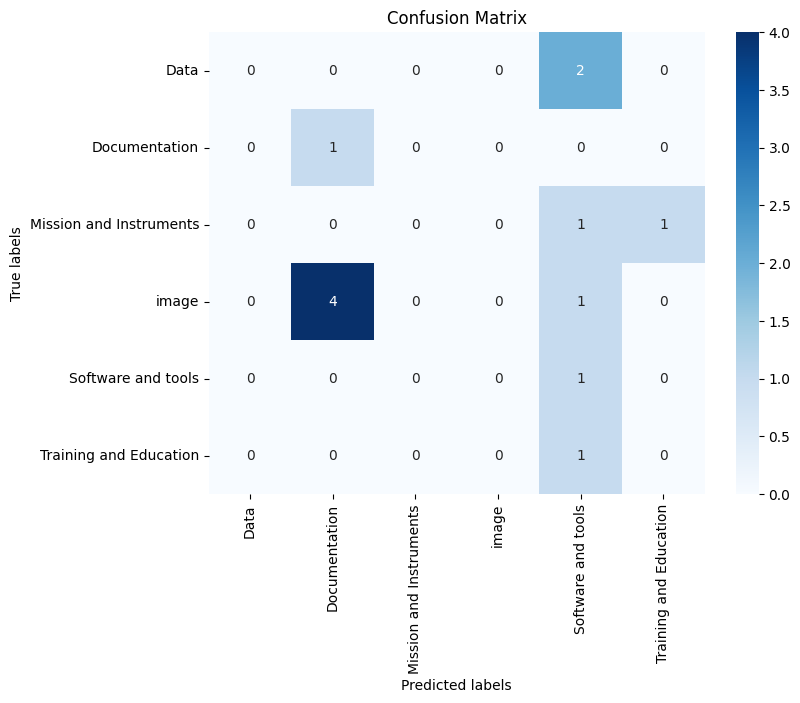

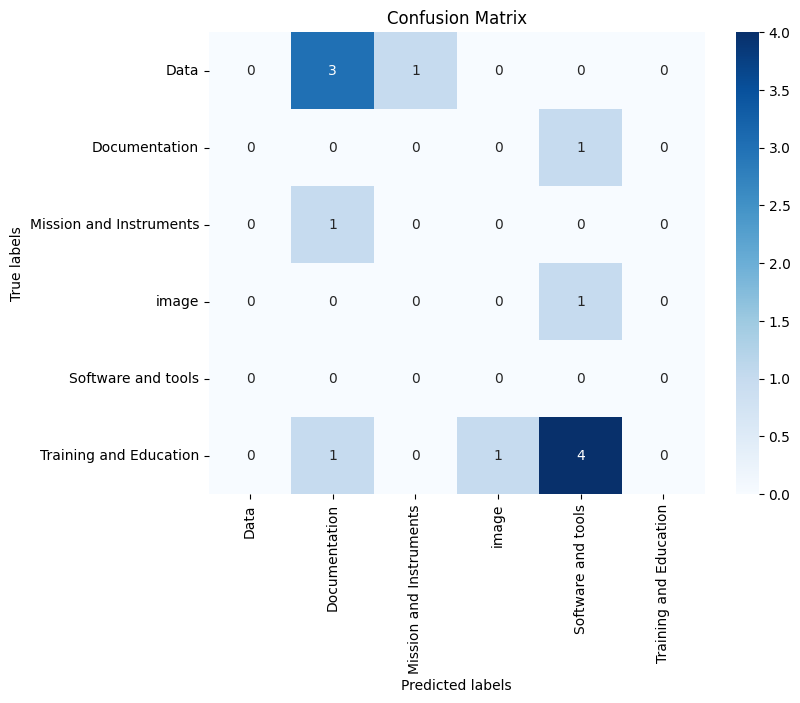

In [15]:
train(config)